In [1]:
pwd

'C:\\Users\\Lenovo X230\\Downloads'

# Imports

In [2]:
# Imports
import numpy as np
import pandas as pd

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Customise our plotting settings
rcParams['figure.figsize'] = 10, 5
sns.set_style('whitegrid')

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

import nltk

# Reading data

In [3]:
data = pd.read_csv('train.csv')
sample_data = pd.read_csv('sample_submission.csv')
testing = pd.read_csv('test.csv')

# Making copies of original data

In [4]:
train = data.copy()
sample = sample_data.copy()
test = testing.copy()

In [5]:
train.info()
# non-null equals number of entries for all columns, that means no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
sentiment    15819 non-null int64
message      15819 non-null object
tweetid      15819 non-null int64
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [ ]:
test.info()

In [ ]:
# Check for the existence of NaN values in a cell:
train.isnull().sum()

In [ ]:
# Check for the existence of NaN values in a cell:
test.isnull().sum()

In [ ]:
train['sentiment'].value_counts()
#the classes are inbalanced, class 1 is more than 50% of the training data.

In [ ]:
#percentage of class 1
len(train[train['sentiment']==1])/len(train) * 100

In [ ]:
#percentage of class 2
len(train[train['sentiment']==2])/len(train) * 100

In [ ]:
#percentage of class 0
len(train[train['sentiment']==0])/len(train) * 100

In [ ]:
#percentage of class -1
len(train[train['sentiment']==-1])/len(train) * 100

# BALANCING CLASSES( upsample minority class + downsample majority class)¶

In [ ]:
train_sum = train[['sentiment', 'message']].groupby('sentiment').count()

In [ ]:
# plot by sentimental classes
train_sum.sort_values('message', ascending=False).plot(kind='bar')
plt.show()

In [6]:
# As usual, we start by importing our modules
from sklearn.utils import resample


In [8]:
#class size equals to 50% of the majority class(can change it to any number which will give best result)



class_size = int(len(train[train['sentiment']==1]))# Upsampling

#class_size = int(len(train[train['sentiment']==1])/2) # upsample minority class + downsample majority class

#class_size = int(len(train[train['sentiment']==-1])) # DownSampling


class_size

#uncomment the others to try them out

4265

In [9]:
one = train[train['sentiment']==1]
two = train[train['sentiment']==2]

In [10]:

one_downsampled = resample(one,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27) # reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([one_downsampled, two])

# Check new class counts
downsampled['sentiment'].value_counts()

1    4265
2    3640
Name: sentiment, dtype: int64

In [11]:
# Upsample minority
two_upsampled = resample(two,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([two_upsampled, one_downsampled])

# Check new class counts
upsampled['sentiment'].value_counts()

2    4265
1    4265
Name: sentiment, dtype: int64

In [12]:
zero = train[train['sentiment']==0]

In [13]:
zero_upsampled = resample(zero,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled0 = pd.concat([zero_upsampled, upsampled])

# Check new class counts
upsampled0['sentiment'].value_counts()

2    4265
1    4265
0    4265
Name: sentiment, dtype: int64

In [14]:
minus_one = train[train['sentiment']==-1]

In [15]:
minus_one_upsampled = resample(minus_one,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled_ = pd.concat([minus_one_upsampled, upsampled0])

# Check new class counts
upsampled_['sentiment'].value_counts()

-1    4265
 2    4265
 1    4265
 0    4265
Name: sentiment, dtype: int64

In [16]:
train=upsampled_ 
train

,sentiment,message,tweetid
12819,-1,@ConnorDukeSmith climate change is fake #iamright,69529
6687,-1,RT @PolitixGal: When govt controls scientific ...,316086
9172,-1,@DRUDGE_REPORT 'Trump veers off script on clim...,106644
12863,-1,I'm going to start replacing 'climate change' ...,527580
1878,-1,RT @goburch: I just aint believing all that gl...,477516
...,...,...,...
2856,1,These beautiful paintings turn depressing clim...,642420
6325,1,"RT @chunkymark: a housing bubble, a mounting d...",672682
10548,1,RT @AllBirdsWiki: @birdsblooms Animal ag is th...,630990
7929,1,"@statesman Scott Pruitt Must Go, and all citiz...",554457


In [17]:
train_sum = train[['sentiment', 'message']].groupby('sentiment').count()

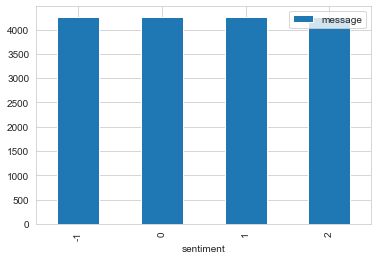

In [18]:
# Plot by sentimental classes
train_sum.sort_values('message', ascending=False).plot(kind='bar')
plt.show()

# PREPROCESSING DATA

In [19]:
# Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test['message'] = test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [20]:
# Make lower case
train['message'] = train['message'].str.lower()
test['message'] = test['message'].str.lower()

In [21]:
# Strip out punctuation marks and numerals
import string
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

train['message'] = train['message'].apply(remove_punctuation_numbers)
test['message'] = test['message'].apply(remove_punctuation_numbers)

In [22]:
train["message"].iloc[1]

'rt politixgal when govt controls scientific research via grant money there is no truth only agenda obama regime pushed global warming'

In [23]:
#Tokenisation
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
tokeniser = TreebankWordTokenizer()
train['message'] = train['message'].apply(tokeniser.tokenize)
test['message'] = test['message'].apply(tokeniser.tokenize)

In [24]:
train["message"].iloc[1]

['rt',
 'politixgal',
 'when',
 'govt',
 'controls',
 'scientific',
 'research',
 'via',
 'grant',
 'money',
 'there',
 'is',
 'no',
 'truth',
 'only',
 'agenda',
 'obama',
 'regime',
 'pushed',
 'global',
 'warming']

In [25]:
#lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

train['message'] = train['message'].apply(mbti_lemma, args=(lemmatizer, ))
test['message'] = test['message'].apply(mbti_lemma, args=(lemmatizer, ))

[nltk_data] Downloading package wordnet to C:\Users\Lenovo
[nltk_data]     X230\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
train["message"].iloc[1]

['rt',
 'politixgal',
 'when',
 'govt',
 'control',
 'scientific',
 'research',
 'via',
 'grant',
 'money',
 'there',
 'is',
 'no',
 'truth',
 'only',
 'agenda',
 'obama',
 'regime',
 'pushed',
 'global',
 'warming']

In [47]:
# Removing Stop Words
from nltk.corpus import stopwords
print(stopwords.words('english'))
def remove_stop_words(tokens):
    return [t for t in tokens if t not in stopwords.words('english')]
train['message'] = train['message'].apply(remove_stop_words)
test['message'] = test['message'].apply(remove_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [48]:
train["message"].iloc[1]

['rt',
 'politixgal',
 'govt',
 'control',
 'scientific',
 'research',
 'via',
 'grant',
 'money',
 'truth',
 'agenda',
 'obama',
 'regime',
 'pushed',
 'global',
 'warming']

In [ ]:
train.head()

# train_test_split

In [49]:
from sklearn.model_selection import train_test_split

X = train['message'].astype(str)
y = train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer(lowercase=False)),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

#Logistic regression(one over the rest)
text_clf_logReg= Pipeline([('tfidf', TfidfVectorizer()),
                          ('clf', LogisticRegression(multi_class='ovr')),
])

# Fitting Naive Bayes

In [51]:
text_clf_nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [52]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

In [53]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[803  20  17  11]
 [ 82 647  74  58]
 [105  61 506 152]
 [ 20  12  42 802]]


In [54]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.80      0.94      0.86       851
           0       0.87      0.75      0.81       861
           1       0.79      0.61      0.69       824
           2       0.78      0.92      0.84       876

    accuracy                           0.81      3412
   macro avg       0.81      0.81      0.80      3412
weighted avg       0.81      0.81      0.80      3412



In [55]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8083235638921453


# Fitting linear SVC

In [56]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [57]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [58]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[823  13   8   7]
 [ 26 768  44  23]
 [ 50  76 587 111]
 [  8  13  42 813]]


In [59]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.91      0.97      0.94       851
           0       0.88      0.89      0.89       861
           1       0.86      0.71      0.78       824
           2       0.85      0.93      0.89       876

    accuracy                           0.88      3412
   macro avg       0.88      0.87      0.87      3412
weighted avg       0.88      0.88      0.87      3412



In [60]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8766119577960141


# Fitting Logistic Regression

In [61]:
text_clf_logReg.fit(X_train, y_train)

C:\Users\Lenovo X230\Anaconda3\ana\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [62]:
# Form a prediction set
predictions = text_clf_logReg.predict(X_test)

In [63]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[763  44  25  19]
 [ 36 704  66  55]
 [ 64  85 531 144]
 [ 12  21  51 792]]


In [64]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.87      0.90      0.88       851
           0       0.82      0.82      0.82       861
           1       0.79      0.64      0.71       824
           2       0.78      0.90      0.84       876

    accuracy                           0.82      3412
   macro avg       0.82      0.82      0.81      3412
weighted avg       0.82      0.82      0.81      3412



In [65]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8177022274325909


# submission to kaggle

In [66]:
sample

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,1


In [67]:
t = sample.copy()
t['sentiment'] = text_clf_lsvc.fit(X_train, y_train).predict(test['message'].astype(str))
t

,tweetid,sentiment
0,169760,2
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0


In [68]:
t.to_csv('sub5.csv', index=False)

In [ ]:
pwd